In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import PIL
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import metrics
from collections import defaultdict
from os import listdir
import os
from joblib import dump, load

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
### Only run if you re-downloaded the files and need to process them into memory
cracked_labels = set()
labels = []
image_files = []
structures = ["D", "P", "W"]

def loadAndScaleImages(filelist):
    print("loadAndScaleImages")
    imgdata = []
    for file in filelist:
        data = imread(file, as_gray=False)
        imgdata.append(data)
    return np.array(imgdata)


if os.path.exists("data/SDNET2018_X.npy"):

    image_data = np.load("data/SDNET2018_X.npy")
    labels = np.load("data/SDNET2018_y.npy")

else:
    for structure in structures:

        img_folder = "data/SDNET2018/" + structure + "/"

        for CU_directory in listdir(img_folder):

            for filename in listdir(img_folder+CU_directory):

                if filename.endswith("jpg"):
                    image_file = img_folder + "/" + CU_directory + "/" + filename
                    image_files.append(image_file)
                    if 'C' in CU_directory:
                        labels.append(1)
                    else:
                        labels.append(0)
                else:
                    print("bad name -> " + filename)

    image_data = loadAndScaleImages(image_files)
    print(image_data.shape)

    labels = np.array(labels)
    print(labels.shape)
    
    save_path_x_data = "data/SDNET2018_X.npy"
    save_path_y_data = "data/SDNET2018_y.npy"

    np.save(save_path_x_data, image_data)
    np.save(save_path_y_data, labels)

loadAndScaleImages
(56092, 256, 256, 3)
(56092,)


In [8]:
#Only run to update the train/test split
print('All X data shape: ', image_data.shape)
print('All y data shape: ', labels.shape)
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X val shape: ', X_test.shape)
print('y val shape: ', y_test.shape)

All X data shape:  (56092, 256, 256, 3)
All y data shape:  (56092,)
X train shape:  (44873, 256, 256, 3)
y train shape:  (44873,)
X val shape:  (11219, 256, 256, 3)
y val shape:  (11219,)


In [41]:
# set class weights for model
class_weight = {0: 0.1,
                 1: 1.0}

In [43]:
def construct_model():

    model_input = Input(shape=(256, 256, 3))
    x = Conv2D(16, kernel_size=3, activation='relu')(model_input)
    x = BatchNormalization()(x)

    x = Conv2D(32, kernel_size=3, activation='relu', strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, kernel_size=3, activation='relu', strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, kernel_size=3, activation='relu', strides=2)(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    model_output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[model_input], outputs=[model_output])

model = construct_model()
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 254, 254, 16)      64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 126, 126, 32)      4640      
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 62, 62, 64)       

In [44]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.Hinge(reduction="auto", name="hinge"), metrics=['accuracy'])

In [77]:
model.fit(X_train, y_train, epochs=5, batch_size=32, class_weight=class_weight)

Epoch 1/5
141/141 [==============================] - 148s 1s/step - loss: 0.2216 - accuracy: 0.8425
Epoch 2/5
141/141 [==============================] - 141s 1s/step - loss: 0.1920 - accuracy: 0.6620
Epoch 3/5
141/141 [==============================] - 140s 992ms/step - loss: 0.1817 - accuracy: 0.6232
Epoch 4/5
141/141 [==============================] - 136s 968ms/step - loss: 0.1845 - accuracy: 0.6003
Epoch 5/5
141/141 [==============================] - 136s 966ms/step - loss: 0.1807 - accuracy: 0.6023


In [47]:
model.save('concrete_0.3.h5')

In [85]:
y_pred = model.predict(X_test)

1656
8158
11219
accuracy:  0.3901417238613067
f1_score:  0.3028326879967393
precision:  0.8973429951690821
recall:  0.18215248835498896


Text(0.5, 1.0, 'CNN PR Curve')

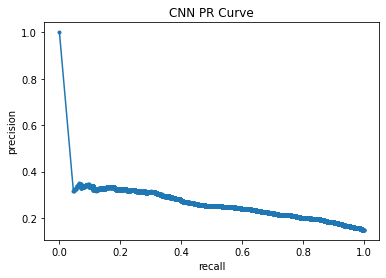

In [90]:
y_pred_thresh = y_pred > 0.5

count = 0
for y in y_pred_thresh:
    if y > 0:
        count += 1

count2 = 0
for y in y_test:
    if y > 0:
        count2 +=1
        
print(count2)
print(count)
print(y_pred.shape[0])
        
print("accuracy: ", accuracy_score(y_pred_thresh, y_test))
print("f1_score: ", f1_score(y_pred_thresh, y_test))
print("precision: ", precision_score(y_pred_thresh, y_test))
print("recall: ", recall_score(y_pred_thresh, y_test))

pr, re, _ = precision_recall_curve(y_test, y_pred)

# plot the precision-recall curves
plt.plot(re, pr, marker='.', label='CNN')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('CNN PR Curve')


In [93]:
small_x_test = X_test[1000:2000]
small_y_test = y_test[1000:2000]
np.save('small_x_data.npy', small_x_test)
np.save('small_y_data.npy', small_y_test)